# **第6章: 機械学習**

本章では，Fabio Gasparetti氏が公開している[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)を用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50 データの入手・整形
[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator) をダウンロードし、以下の要領で学習データ（`train.txt`），検証データ（`valid.txt`），評価データ（`test.txt`）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
1. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
1. 抽出された事例をランダムに並び替える．
1. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれ`train.txt`，`valid.txt`，`test.txt`というファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2023-04-11 21:27:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: 'NewsAggregatorDataset.zip'

NewsAggregatorDatas 100%[===================>]  27.87M  7.98MB/s    in 3.7s    

2023-04-11 21:27:43 (7.48 MB/s) - 'NewsAggregatorDataset.zip' saved [29224203/29224203]



In [2]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [1]:
#Alternative: from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

df = pd.read_csv('newsCorpora.csv', sep='\t', names=('id','title','url','publisher','category','story','hostname','timestamp'))
df = df[(df['publisher'] == 'Reuters') |
   (df['publisher'] == 'Huffington Post') |
   (df['publisher'] == 'Businessweek') |
   (df['publisher'] == 'Businessweek') |
   (df['publisher'] == 'Contactmusic.com') |
   (df['publisher'] == 'Daily Mail')]
#Alternative: df = df.loc[df['publisher'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]

df = df.sample(frac=1)

ratio_train, ratio_valid = 0.8, 0.1
n_train, n_valid = (np.array([ratio_train, ratio_valid]) * len(df)).astype(int)

train = df.iloc[:n_train]
valid = df.iloc[n_train:n_train+n_valid]
test = df.iloc[n_train+n_valid:]

train.to_csv('train.txt', header=False, index=False, sep='\t')
valid.to_csv('valid.txt', header=False, index=False, sep='\t')
test.to_csv('test.txt', header=False, index=False, sep='\t')

print('-TRAIN-')
print(train['category'].value_counts())
print('-VALID-')
print(valid['category'].value_counts())
print('-TEST-')
print(test['category'].value_counts())

-TRAIN-
b    4466
e    4266
t    1219
m     721
Name: category, dtype: int64
-VALID-
b    587
e    524
t    135
m     88
Name: category, dtype: int64
-TEST-
b    574
e    489
t    170
m    101
Name: category, dtype: int64


## 51 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれ`train.feature.txt`，`valid.feature.txt`，`test.feature.txt`というファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [2]:
#Alternative: from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle

train_corpus = train['title'].values
valid_corpus = valid['title'].values
test_corpus = test['title'].values

vectorizer = CountVectorizer(stop_words='english')
#vectorizer = TfidfVectorizer(stop_words='english')
train_feature = vectorizer.fit_transform(train_corpus)
valid_feature = vectorizer.transform(valid_corpus)
test_feature = vectorizer.transform(test_corpus)

features = vectorizer.get_feature_names_out()

train_feature_df = pd.DataFrame(train_feature.toarray(), columns = features)
valid_feature_df = pd.DataFrame(valid_feature.toarray(), columns = features)
test_feature_df = pd.DataFrame(test_feature.toarray(), columns = features)

pickle.dump(train_feature_df, open('train.feature.txt', 'wb'))
pickle.dump(valid_feature_df, open('valid.feature.txt', 'wb'))
pickle.dump(test_feature_df, open('test.feature.txt', 'wb'))

#train_feature_df.to_csv('train.feature.txt', header=False, index=False, sep='\t')
#valid_feature_df.to_csv('valid.feature.txt', header=False, index=False, sep='\t')
#test_feature_df.to_csv('test.feature.txt', header=False, index=False, sep='\t')

## 52 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [20]:
from sklearn.linear_model import LogisticRegression

X = train_feature
y = train['category']
clf = LogisticRegression(max_iter=200).fit(X, y)

## 53 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [21]:
def predict(title):
    feature = vectorizer.transform([title])
    result = clf.predict(feature)[0]
    proba = max(clf.predict_proba(feature)[0])
    return result, proba

predict('test movie')

('e', 0.7354281793093395)

## 54 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [22]:
from sklearn.metrics import accuracy_score

def get_prediction(df):
    return np.vectorize(predict)(df['title'])[0]

prediction_train = get_prediction(train)
prediction_valid = get_prediction(valid)
prediction_test = get_prediction(test)

print('accuracy@train:')
print(accuracy_score(train['category'], prediction_train), '\n')

print('accuracy@test:')
print(accuracy_score(test['category'], prediction_test))

accuracy@train:
0.9951274362818591 

accuracy@test:
0.9092953523238381


## 55 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [23]:
from sklearn.metrics import confusion_matrix
#lesson learned: use heat map instead

labels = ['b','t','e','m']

confusion_matrix_train =  confusion_matrix(train['category'], prediction_train, labels=labels)
confusion_matrix_test =  confusion_matrix(test['category'], prediction_test, labels=labels)

print('confusion_matrix@train:\n')
print(pd.DataFrame(confusion_matrix_train, index=labels, columns=labels), '\n')

print('confusion_matrix@test:\n')
print(pd.DataFrame(confusion_matrix_test, index=labels, columns=labels))

confusion_matrix@train:

      b     t     e    m
b  4449    10     6    1
t    15  1199     5    0
e     7     1  4258    0
m     3     0     4  714 

confusion_matrix@test:

     b    t    e   m
b  548   11   11   4
t   26  117   24   3
e    6    1  480   2
m   15    1   17  68


## 56 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [25]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from statistics import harmonic_mean

result = precision_recall_fscore_support(test['category'], prediction_test, labels = labels)[:3]
result_df = pd.DataFrame(result, index=['precision', 'recall', 'fscore'], columns=labels)
result_df['macro'] = np.array(result).mean(axis=1)

p_micro = precision_score(test['category'], prediction_test, average='micro')
r_micro = recall_score(test['category'], prediction_test, average='micro')
f_micro = harmonic_mean([p_micro, r_micro])
result_df['micro'] = [p_micro, r_micro, f_micro]
#↑ ここでp_microなどはみんなaccuracyと同等になるので、この前のaccuracyの結果をそのまま使ってもいいかも

display(pd.DataFrame(result_df))

,b,t,e,m,macro,micro
precision,0.921008,0.900000,0.902256,0.883117,0.901595,0.909295
recall,0.954704,0.688235,0.981595,0.673267,0.824450,0.909295
fscore,0.937553,0.780000,0.940255,0.764045,0.855463,0.909295


## 57 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [26]:
weights = np.abs(clf.coef_).mean(axis=0)
feature_names = vectorizer.get_feature_names_out()
index = [i for i in range(1, 11)]

# cf. https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array

def get_best_ind(weights):
    ind = np.argpartition(weights, -10)[-10:]
    ind = ind[np.argsort(weights[ind])]
    return ind[::-1]

def get_worst_ind(weights):
    ind = np.argpartition(weights, 9)[:10]
    ind = ind[np.argsort(weights[ind])]
    return ind
                                                                                 
result_df = pd.DataFrame(index = index)
result_df['Best 10'] = feature_names[get_best_ind(weights)]
result_df['Worst 10'] = feature_names[get_worst_ind(weights)]
display(result_df)

,Best 10,Worst 10
1,ebola,1399985295432
2,google,1399985294870
3,facebook,cmgcontent_internallink_relatedcontent_2014_pa...
4,microsoft,8001233
5,apple,icmp
6,climate,149002
7,fda,148948
8,gm,id
9,activision,riddler
10,cancer,1399985295162


In [27]:
#謎のbeyonces (ちゃんとstemmingしなかったせい？)

print(list(zip(*clf.coef_))[vectorizer.vocabulary_['beyonces']])
print(list(zip(*clf.coef_))[vectorizer.vocabulary_['beyonce']])

(-3.0851627490560905e-06, 5.916631859909418e-06, -1.3215385419351126e-06, -1.5099305689183263e-06)
(-0.6324102549165361, 1.335478475451997, -0.30320199647654156, -0.3998662240589192)


In [28]:
#adapted from https://amaru-ai.com/entry/2022/10/12/202559

for c, coef in zip(clf.classes_, clf.coef_):
    print(f'【カテゴリ】{c}')
    
    #best10 = pd.DataFrame(feature_names[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
    best10 = pd.DataFrame(feature_names[get_best_ind(coef)], columns=['重要度上位'], index=index).T
    
    #worst10 = pd.DataFrame(feature_names[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
    worst10 = pd.DataFrame(feature_names[get_worst_ind(coef)], columns=['重要度下位'], index=index).T
    
    display(pd.concat([best10, worst10], axis=0))
    print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,fed,ecb,obamacare,china,argentina,dollar,ukraine,uber,oil
重要度下位,activision,aereo,nintendo,ebola,twitch,cap,virus,subscription,sony,heart




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,paul,miley,movie,cyrus,beyonce,hbo,cannes,jay
重要度下位,google,facebook,china,microsoft,study,gm,billion,data,oil,scientists




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,fda,cancer,mers,drug,study,cases,cigarettes,cdc,health
重要度下位,gm,dimon,facebook,apple,climate,buy,netflix,fed,sell,twitter




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,microsoft,apple,climate,activision,heartbleed,nasa,tesla,fcc
重要度下位,stocks,percent,valued,shares,upholds,men,grows,fed,kids,drug


In [30]:
#get_best_ind is more efficient

import cProfile
cProfile.run('np.argsort(weights)')#O(nlogn)
cProfile.run('get_best_ind(weights)')#O(n + klogk)

         10 function calls in 0.002 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.002    0.002 <__array_function__ internals>:2(argsort)
        1    0.000    0.000    0.002    0.002 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:1002(_argsort_dispatcher)
        1    0.000    0.000    0.002    0.002 fromnumeric.py:1006(argsort)
        1    0.000    0.000    0.002    0.002 fromnumeric.py:51(_wrapfunc)
        1    0.000    0.000    0.002    0.002 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
        1    0.000    0.000    0.002    0.002 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.002    0.002    0.002    0.002 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' object

## 58 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [31]:
import matplotlib.pyplot as plt

strengths = np.linspace(0.001, 2, num=10)

acc_train = []
acc_valid = []
acc_test = []

for strength in strengths:
    clf = LogisticRegression(max_iter=1000, C = 1/strength).fit(X, y)
    acc_train.append(accuracy_score(train['category'], get_prediction(train)))
    acc_valid.append(accuracy_score(valid['category'], get_prediction(valid)))
    acc_test.append(accuracy_score(test['category'], get_prediction(test)))

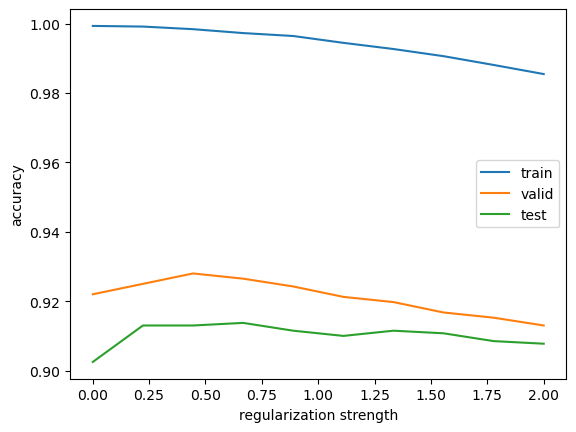

In [32]:
plt.plot(strengths, acc_train, label='train')
plt.plot(strengths, acc_valid, label='valid')
plt.plot(strengths, acc_test, label='test')
plt.xlabel('regularization strength')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [33]:
#adapted from https://amaru-ai.com/entry/2022/10/12/202559

# lesson learned:
# 1. use tqdm to show progress
# 2. use logspace to cover wider range

from tqdm import tqdm

result = []

for C in tqdm(np.logspace(-5, 4, 10, base=10)):
    # モデルの学習
    clf = LogisticRegression(random_state=123, max_iter=10000, C=C).fit(X, y)

    # 正解率の算出
    train_accuracy = accuracy_score(train['category'], get_prediction(train))
    valid_accuracy = accuracy_score(valid['category'], get_prediction(valid))
    test_accuracy = accuracy_score(test['category'], get_prediction(test))

    # 結果の格納
    result.append([C, train_accuracy, valid_accuracy, test_accuracy])

result = np.array(result).T

100%|█████████████████████████████████████████████| 10/10 [00:35<00:00,  3.60s/it]


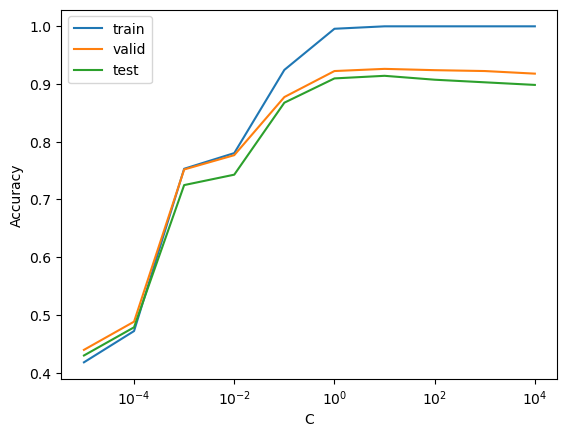

In [34]:
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

## 59 ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [35]:
from sklearn.linear_model import LogisticRegressionCV

lg = LogisticRegressionCV(max_iter=1000, random_state=42, cv=5)
clf = lg.fit(X, y)
prediction_valid = get_prediction(valid)
accuracy_score(valid['category'], prediction_valid)

0.9272863568215892

In [36]:
prediction_test = get_prediction(test)
accuracy_score(test['category'], prediction_test)

0.9100449775112444

In [13]:
#思った以上時間かかりそう...
#Consider HalvingGridSearchCV, HalvingRandomSearchCV, optuna
#cf. https://scikit-learn.org/stable/modules/grid_search.html#
#cf. https://amaru-ai.com/entry/2022/10/12/202559

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

transformer = MaxAbsScaler().fit(X)
X = transformer.transform(X)

lg = LogisticRegression(max_iter=1000, random_state=42, penalty='elasticnet', solver='saga')
parameters = {'l1_ratio': [0, 0.5, 1]}
clf = GridSearchCV(lg, parameters)
clf.fit(X, y)

In [68]:
from sklearn.datasets import load_iris
from sklearn.linear_model import SGDClassifier

X, y = load_iris(return_X_y=True)
sgd1 = SGDClassifier(max_iter=1, random_state=42)
clf1 = sgd1.fit(X, y)

/Users/zhu/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [69]:
sgd2 = SGDClassifier(random_state=42)
clf2 = sgd2.partial_fit(X, y, classes=sgd1.classes_)

In [70]:
np.abs(sgd1.coef_ - sgd2.coef_).max()

0.0